In [1]:
import numpy as np
import tensorflow as tf

### Generating two classes of random points in a 2D plane
First, let’s come up with some nicely linearly separable synthetic data to work with: two classes of points in a 2D plane. 

We’ll generate each class of points by drawing their coordinates from a random distribution with a specific covariance matrix and a specific mean.


- The **covariance matrix parameter** is a square matrix that describes the spread (variance) of each dimension and how the dimensions vary togther (covariance);
- The **mean parameter** is a vector that represents the center (or average position) of the data distribution in the plane.

We’ll reuse the same covariance matrix for both point clouds, but we’ll use two different mean values—the point clouds will have the same shape, but different positions.
<p align="center">
    <img src="images\mean-and-covariance-visualized.png" width="50%">
</p>

In [2]:
num_samples_per_class = 1000

# Generate the first class of points, an oval-like point cloud oriented from bottom left to top right 
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

# Generate the other class of points with different mean and the same covariance matrix
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

In [3]:
negative_samples.shape

(1000, 2)

In [4]:
positive_samples.shape

(1000, 2)

### Stacking the two classes into an array
In the preceeding code, ```negative_samples``` and ```positive_samples``` are both arrays with shape ```(1000, 2)```.

We can **stack** the two arrays of samples into a single array of shape ```(2000, 2)``` using ```np.vstack```, for appending data **vertically**.

<p align="center">
    <img src="images\vstack.png" width="20%">
</p>

In case we need to append data **horizontally**, we can use the ```np.hstack```.

<p align="center">
    <img src="images\hstack.png" width="50%">
</p>

In [5]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
# inputs = np.hstack((negative_samples, positive_samples)).astype(np.float32)
inputs

array([[-0.58441114,  1.6837131 ],
       [ 0.72460747,  1.8016804 ],
       [ 0.9764085 ,  4.873658  ],
       ...,
       [ 4.330743  , -0.44223887],
       [ 1.889392  , -0.5392661 ],
       [ 2.7212813 ,  0.39420313]], dtype=float32)

In [6]:
inputs.shape

(2000, 2)

### Generating the corresponding targets
Let’s generate the corresponding **target labels**, an array of zeros and ones of shape
```(2000, 1)```, where _targets[i, 0]_ is 0 if _inputs[i]_ belongs to class 0 (and inversely).

In [7]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))
targets

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

### Plotting the two point classes
We can visualize the data points generated using _Matplotlib_ library.

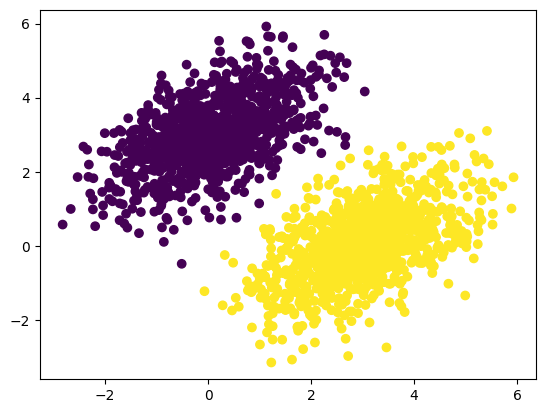

In [8]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

## Building the linear classifier
A linear classifier is a transformation of the type:
```math 
prediction = W \cdot input + b
```
Where:
- **W** is a vector of parameters that the model **learns** during training. Each element in $W$ corresponds to a weight that multiplies an input feature, effectively determining the importance of that feature in the prediction;
- **b** is a scalar (or vector for multiple outputs) that is **added to the weighted sum**. It allows the decision boundary (or hyperplane) to shift away from the origin, providing more flexibility in fitting the data.

### Creating the linear classifier variables
Let’s create our variables, $W$ and $b$, initialized with random values and with zeros,
respectively.
The input dimension is equal to 2 because the classifier operates on 2D point inputs:
- $W = [[w_1], [w_2]]$
- $b$ is a single scalar coefficient

The output dimension is equal to 1 because the prediction will be a single score per sample.

In [9]:
input_dim = 2
output_dim = 1

W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

### The forward pass function
For a given input point $[x,y]$, the prediction will be computed as:
```math
prediction = [[w_1, w_2]] \cdot [x,y] + b = w_1 * x + w_2 * y + b
```

To apply this type of transformation we define the forward pass function:

In [10]:
def model(inputs):
    return tf.matmul(inputs, W) + b

### The loss function
The goal of the classifier is to **minimize** the square of the difference between the predicted and the actual targets.
To keep track of the difference we can employ the following loss function:

In [11]:
def square_loss(targets, predictions):
    # per_sample_losses is a tensor with the same shape as targets and predictions, containing per-sample loss scores
    per_sample_losses = tf.square(targets - predictions)

    # we use reduce_mean to average the per-sample loss scores into a single scalar loss
    # it also normalize the loss, making it independent of the number of samples
    return tf.reduce_mean(per_sample_losses)

### The training step function and training loop
Next is the training step, which receives some training data and updates the weights $W$
and $b$ so as to minimize the loss on the data.

For simplicity, we’ll do ```batch training``` instead of ```mini-batch training```: we’ll run each training step (gradient computation and weight update) for all the data, rather than iterate over the data in small batches.

On one hand, this means that each training step will take much longer to run, since we’ll compute the forward pass and the gradients for 2,000 samples at once.

On the other hand, each gradient update will be much more effective at reducing the loss on the training data, since it will encompass information from all training samples.

As a result, we will need many fewer steps of training, and we should use a larger learning rate than we would typically use for mini-batch training.


In [12]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

In [13]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 6.4823
Loss at step 1: 0.9405
Loss at step 2: 0.2686
Loss at step 3: 0.1631
Loss at step 4: 0.1391
Loss at step 5: 0.1276
Loss at step 6: 0.1185
Loss at step 7: 0.1104
Loss at step 8: 0.1030
Loss at step 9: 0.0962
Loss at step 10: 0.0900
Loss at step 11: 0.0844
Loss at step 12: 0.0792
Loss at step 13: 0.0745
Loss at step 14: 0.0702
Loss at step 15: 0.0663
Loss at step 16: 0.0627
Loss at step 17: 0.0594
Loss at step 18: 0.0563
Loss at step 19: 0.0536
Loss at step 20: 0.0511
Loss at step 21: 0.0488
Loss at step 22: 0.0466
Loss at step 23: 0.0447
Loss at step 24: 0.0430
Loss at step 25: 0.0413
Loss at step 26: 0.0399
Loss at step 27: 0.0385
Loss at step 28: 0.0373
Loss at step 29: 0.0362
Loss at step 30: 0.0351
Loss at step 31: 0.0342
Loss at step 32: 0.0333
Loss at step 33: 0.0325
Loss at step 34: 0.0318
Loss at step 35: 0.0312
Loss at step 36: 0.0306
Loss at step 37: 0.0300
Loss at step 38: 0.0295
Loss at step 39: 0.0290


### Plotting predictions
Because our targets are zeros and ones, a given input point will be classified as “0” if its prediction value is below 0.5, and as “1” if it is above 0.5.

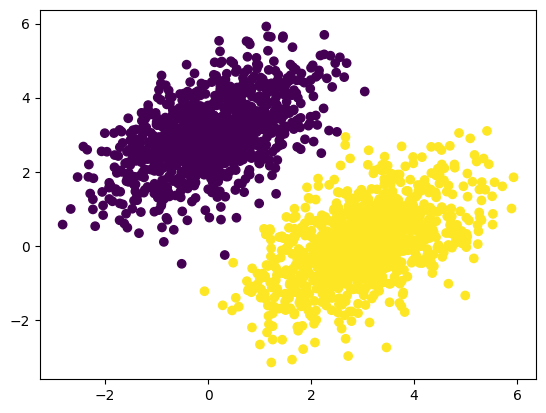

In [14]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

We can now plot the line which separates our two data classes:

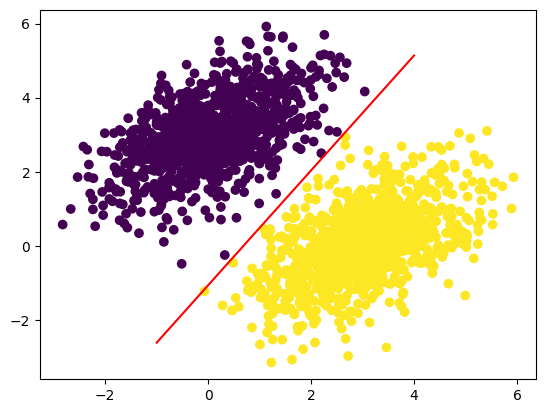

In [15]:
# Generate 100 regurarly spaced numbers between -1 and 4, which we will use to plot our line
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1] # our line equation
plt.plot(x, y, "-r") # plot our line
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5) # plot our model's predictions